# **Data Loading**

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import gdown

file_id = "1hqv9VWk_iu1EQAyauLFCFY7GfEInPRsC"
url = f"https://drive.google.com/uc?id={file_id}"

output = "Mura.zip"
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1hqv9VWk_iu1EQAyauLFCFY7GfEInPRsC
From (redirected): https://drive.google.com/uc?id=1hqv9VWk_iu1EQAyauLFCFY7GfEInPRsC&confirm=t&uuid=7f3fbf7c-7c9b-4cec-ad07-dff8fb0ccdd6
To: /content/Mura.zip
100%|██████████| 3.38G/3.38G [01:06<00:00, 50.7MB/s]


'Mura.zip'

In [3]:
import zipfile, os

# Giải nén
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall("./data")

print(os.listdir("./data"))

['MURA-v1.1']


In [4]:
import glob

train_imgs = glob.glob("./data/MURA-v1.1/train/*/*")
valid_imgs = glob.glob("./data/MURA-v1.1/valid/*/*")

print("Số patience train:", len(train_imgs))
print("Số patience valid:", len(valid_imgs))

Số patience train: 12934
Số patience valid: 1118


In [5]:
import os, glob
from collections import defaultdict

base_dir = "./data/MURA-v1.1"

body_parts = ["XR_ELBOW", "XR_FINGER", "XR_FOREARM", "XR_HUMERUS",
              "XR_SHOULDER", "XR_HAND", "XR_WRIST"]

data_summary = defaultdict(dict)

for part in body_parts:
    train_imgs = glob.glob(os.path.join(base_dir, "train", part, "*"))
    valid_imgs = glob.glob(os.path.join(base_dir, "valid", part, "*"))
    data_summary[part]["train"] = len(train_imgs)
    data_summary[part]["valid"] = len(valid_imgs)

for k,v in data_summary.items():
    print(f"{k}: train={v['train']}, valid={v['valid']}")


XR_ELBOW: train=1711, valid=152
XR_FINGER: train=1865, valid=166
XR_FOREARM: train=865, valid=129
XR_HUMERUS: train=587, valid=132
XR_SHOULDER: train=2694, valid=173
XR_HAND: train=1945, valid=159
XR_WRIST: train=3267, valid=207


In [6]:
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

Device: cuda


In [7]:
import pandas as pd

def collect_items(root_split_dir):
    items = []
    for f in glob.glob(os.path.join(root_split_dir, "*", "*", "*", "*")):
        fl = f.lower()
        if fl.endswith((".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")):
            y = 1 if "positive" in fl else 0
            items.append({"image": f, "label": y})
    return pd.DataFrame(items)

In [8]:
val_df = collect_items('/content/data/MURA-v1.1/valid')

In [9]:
val_df.head()

,image,label
0,/content/data/MURA-v1.1/valid/XR_SHOULDER/pati...,0
1,/content/data/MURA-v1.1/valid/XR_SHOULDER/pati...,0
2,/content/data/MURA-v1.1/valid/XR_SHOULDER/pati...,0
3,/content/data/MURA-v1.1/valid/XR_SHOULDER/pati...,1
4,/content/data/MURA-v1.1/valid/XR_SHOULDER/pati...,1


In [10]:
len(val_df)

3197

In [11]:
train_df = collect_items('/content/data/MURA-v1.1/train')

In [12]:
len(train_df)

36808

In [13]:
train_df.head()

,image,label
0,/content/data/MURA-v1.1/train/XR_SHOULDER/pati...,0
1,/content/data/MURA-v1.1/train/XR_SHOULDER/pati...,0
2,/content/data/MURA-v1.1/train/XR_SHOULDER/pati...,0
3,/content/data/MURA-v1.1/train/XR_SHOULDER/pati...,0
4,/content/data/MURA-v1.1/train/XR_SHOULDER/pati...,1


In [14]:
train_df['label'].value_counts() / len(train_df)

,count
label,
0,0.59593
1,0.40407


In [15]:
val_df['label'].value_counts() / len(val_df)

,count
label,
0,0.521426
1,0.478574


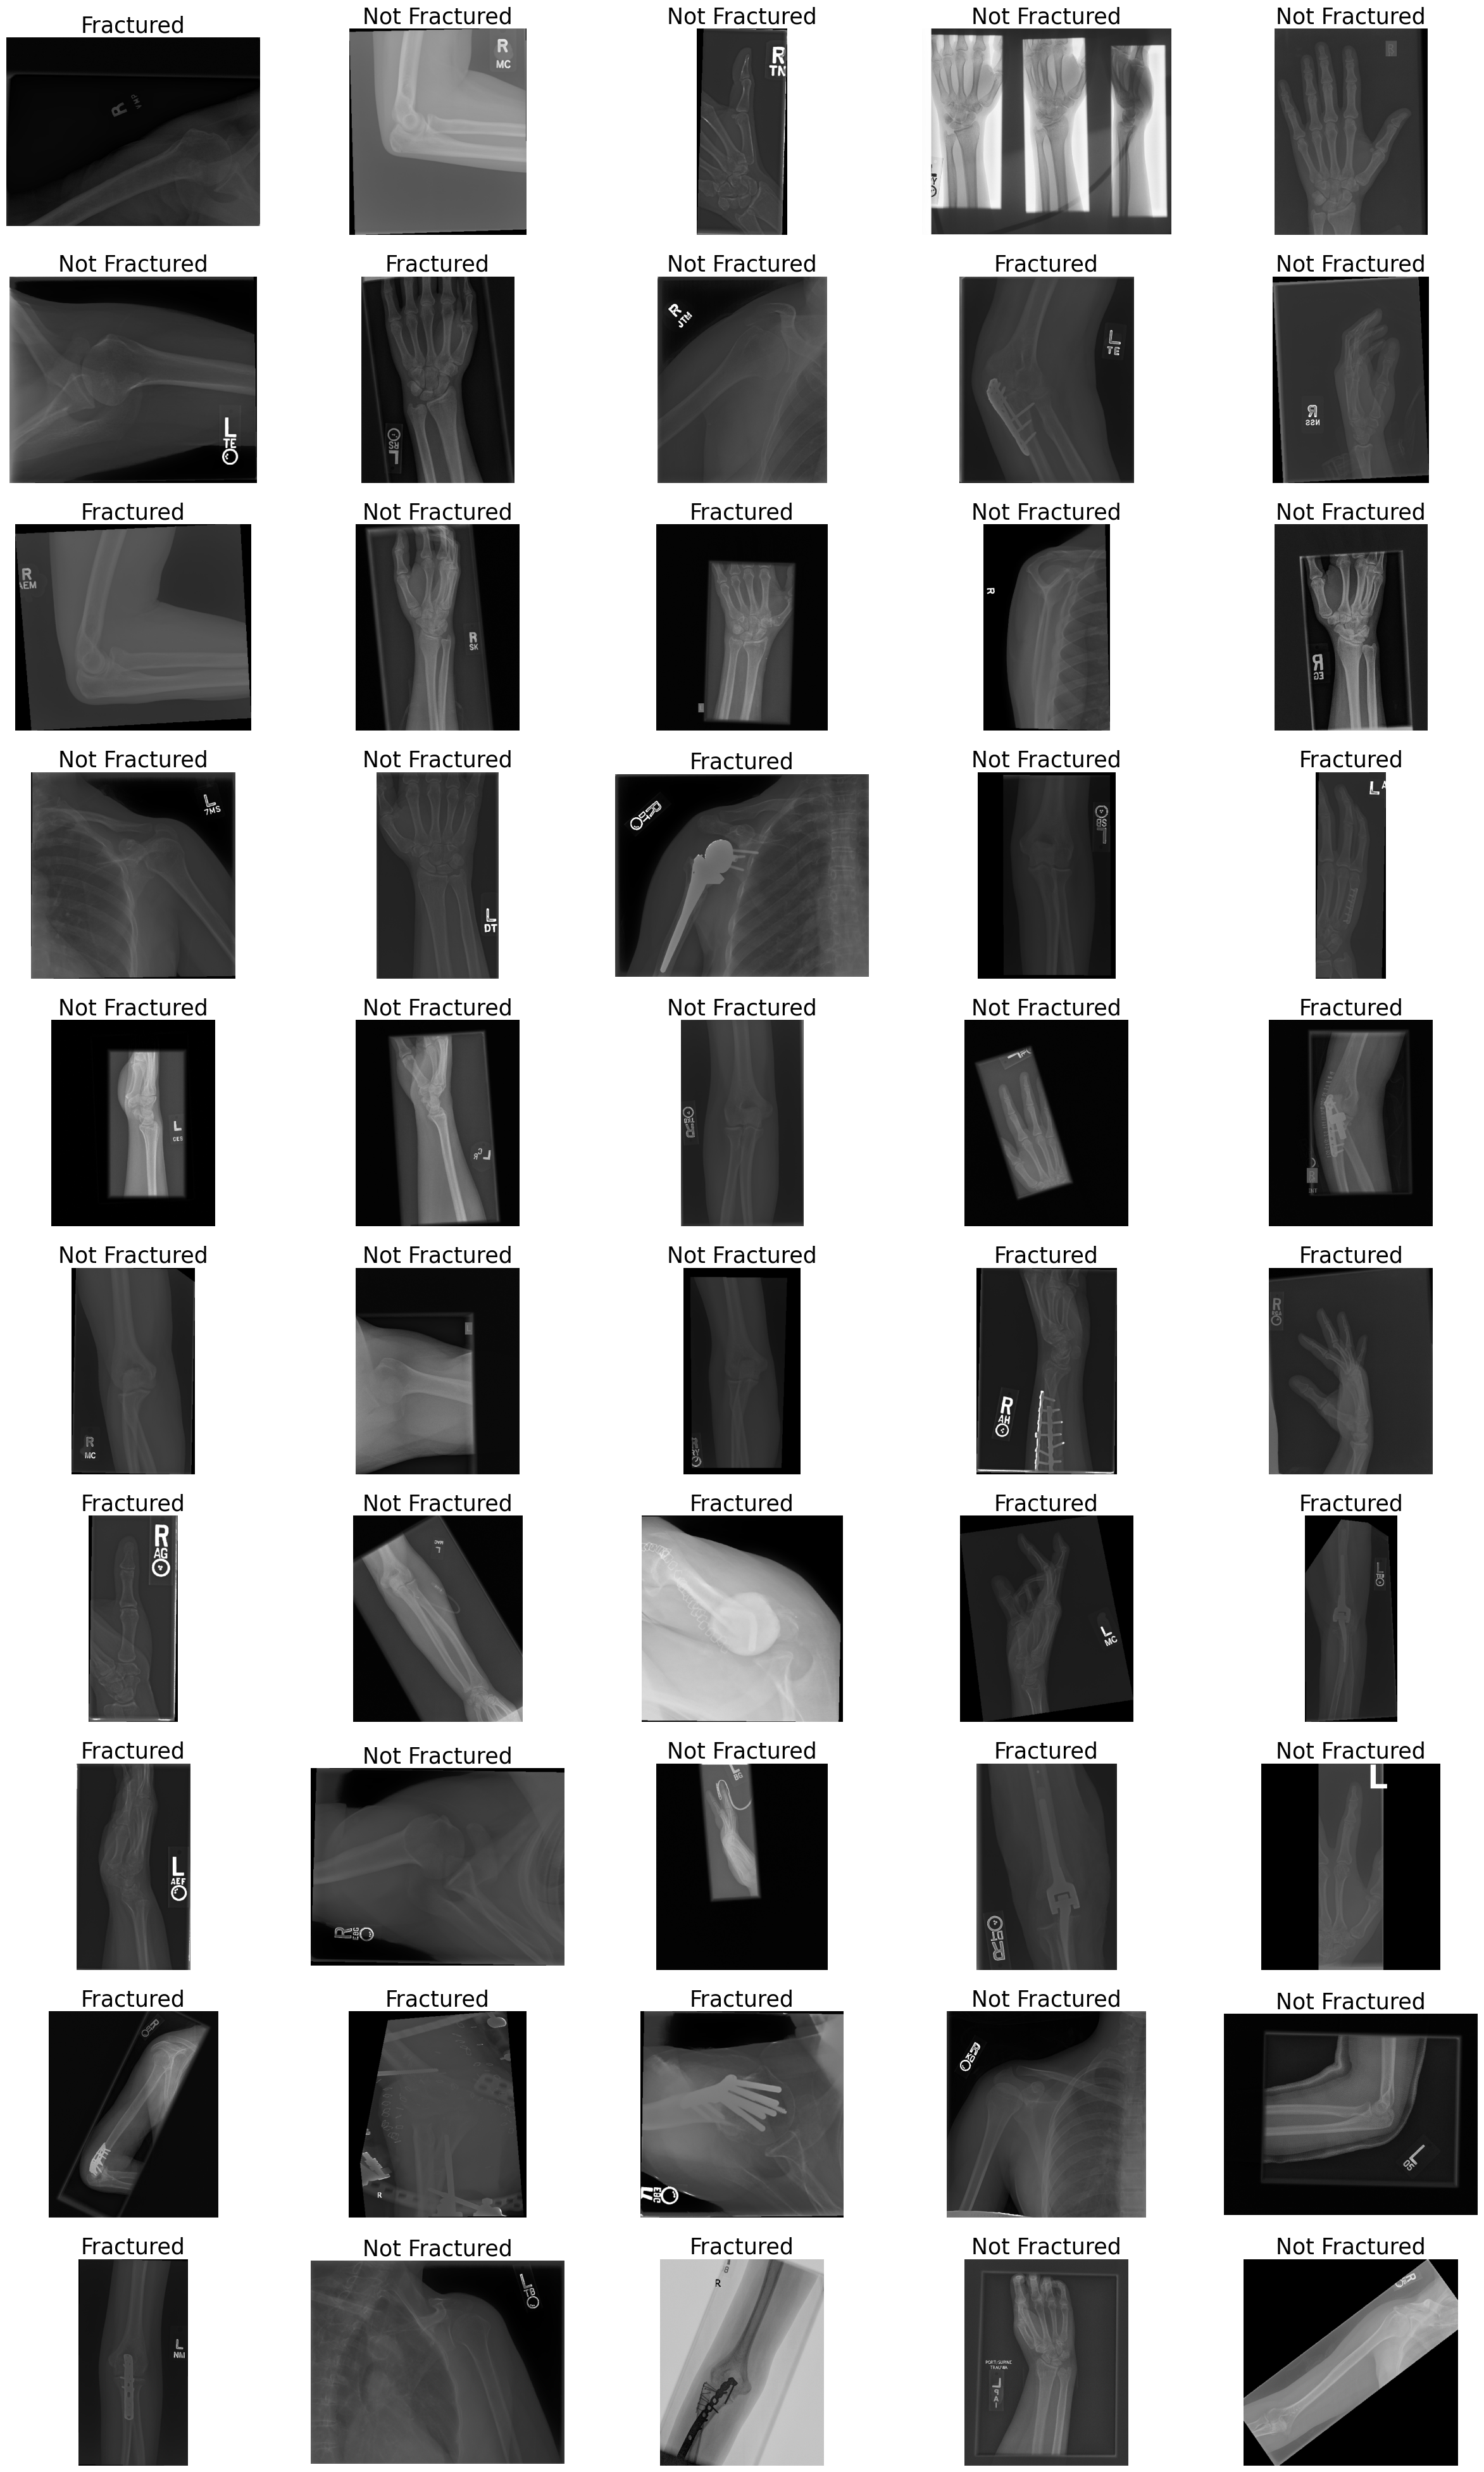

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

plt.figure(figsize=(30, 50))
for n, i in enumerate(np.random.randint(0, len(train_df), 50)):
    plt.subplot(10, 5, n+1)
    img = cv2.imread(train_df.iloc[i, 0])
    plt.imshow(img)
    plt.axis('off')
    plt.title("Fractured" if train_df.label[i] == 1 else "Not Fractured", fontsize=25)

# **Training**

In [17]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 47.6 MB/s eta 0:00:00


In [18]:
import random
import monai

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
monai.utils.set_determinism(seed=42, additional_settings=None)
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
LR = 1e-4
WEIGHT_DECAY = 1e-4
PATIENCE = 4

In [ ]:
from torchvision.models import resnet50
from monai.metrics import ROCAUCMetric

model = resnet50(weights="IMAGENET1K_V2").to(DEVICE)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
auc_metric = ROCAUCMetric()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 99.6MB/s]


In [19]:
import numpy as np
from monai.transforms import (
    Compose,
    LoadImage,
    EnsureChannelFirst,
    EnsureType,
    Lambda,
    ScaleIntensityRange,
    Resize,
    RandFlip,
    RandRotate,
)

def to_3ch(img_tensor):
    if img_tensor.shape[0] == 1:
        return img_tensor.repeat(3, 1, 1)
    return img_tensor


train_tfms = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    EnsureType(dtype=np.float32),
    Lambda(func=to_3ch),
    ScaleIntensityRange(a_min=0, a_max=255, b_min=0.0, b_max=1.0, clip=True),
    Resize(spatial_size=(IMG_SIZE, IMG_SIZE)),
    RandFlip(spatial_axis=1, prob=0.5),
    RandRotate(range_x=np.deg2rad(7), prob=0.5, keep_size=True),
])

valid_tfms = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    EnsureType(dtype=np.float32),
    Lambda(func=to_3ch),
    ScaleIntensityRange(a_min=0, a_max=255, b_min=0.0, b_max=1.0, clip=True),
    Resize(spatial_size=(IMG_SIZE, IMG_SIZE)),
])

In [21]:
test_frac = 0.1
num_total = len(train_df)
indices = np.arange(num_total)
np.random.shuffle(indices)

test_split = int(test_frac * num_total)
test_indices = indices[:test_split]
train_indices = indices[test_split:]

train_x = [train_df['image'][i] for i in train_indices]
train_y = [train_df['label'][i] for i in train_indices]
test_x = [train_df['image'][i] for i in test_indices]
test_y = [train_df['label'][i] for i in test_indices]

indices_val = np.arange(len(val_df))
np.random.shuffle(indices_val)
val_x = [val_df['image'][i] for i in indices_val]
val_y = [val_df['label'][i] for i in indices_val]

print(f"Training count: {len(train_y)}, Validation count: {len(val_y)}, Test count: {len(test_y)}")

Training count: 33128, Validation count: 3197, Test count: 3680


In [22]:
from monai.data import Dataset
from torch.utils.data import DataLoader

class MuraDataset(Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

train_ds = MuraDataset(train_x, train_y, train_tfms)
train_loader = DataLoader(train_ds, batch_size=32, num_workers=2)

test_ds = MuraDataset(test_x, test_y, valid_tfms)
test_loader = DataLoader(test_ds, batch_size=32, num_workers=2)

val_ds = MuraDataset(val_x, val_y, valid_tfms)
val_loader = DataLoader(val_ds, batch_size=32, num_workers=2)

In [23]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        """
        :param patience: Số epoch không cải thiện sau đó sẽ dừng
        :param delta: Cải thiện tối thiểu để tính là sự cải thiện (nếu delta > 0 thì metric phải cải thiện hơn một giá trị nhất định)
        """
        self.patience = patience
        self.delta = delta
        self.best_metric = None
        self.best_epoch = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, metric, epoch):
        # Nếu đây là lần chạy đầu tiên
        if self.best_metric is None:
            self.best_metric = metric
            self.best_epoch = epoch
        # Nếu metric tốt hơn, cập nhật và reset counter
        elif metric < self.best_metric - self.delta:
            self.best_metric = metric
            self.best_epoch = epoch
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

In [24]:
os.makedirs("./model")

In [ ]:
from torch.utils.tensorboard import SummaryWriter

best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

early_stopping = EarlyStopping(patience=5, delta=0.01)

for epoch in range(EPOCHS):
    print("-"*10)
    print(f"epoch {epoch + 1}/{EPOCHS}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(DEVICE), batch_data[1].to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        # Đảm bảo epoch_len được tính toán trước khi sử dụng
        epoch_len = len(train_loader)
        if step % 50 == 0:
            print(f"{step}/{epoch_len}, " f"train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % 1 == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=DEVICE)
            y = torch.tensor([], dtype=torch.long, device=DEVICE)

            # 1. Thu thập dự đoán và nhãn
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(DEVICE),
                    val_data[1].to(DEVICE)
                )
                val_outputs = model(val_images)

                y_pred = torch.cat([y_pred, val_outputs], dim=0)
                y = torch.cat([y, val_labels], dim=0)

            # --- KHU VỰC ĐÁNH GIÁ (Đã sửa cho 2 classes) ---

            # Đối với 2 classes, AUC cần xác suất (probability) của lớp tích cực (positive class).
            # Giả sử lớp tích cực là lớp thứ 1 (chỉ số 1).
            # MONAI Output thường là logits, cần Sigmoid cho Binary AUC
            y_pred_prob = torch.sigmoid(y_pred[:, 1]) # Lấy xác suất của lớp 1 sau Sigmoid

            # Tính AUC (sử dụng MONAI AUC Metric - cần y_pred và y)
            # Giả sử 'auc_metric' được khởi tạo là 'DiceMetric' hoặc tương tự
            # Tái tạo lại logic tính AUC mà không cần one-hot nếu dùng thư viện khác

            # Nếu bạn dùng MONAI ROCAUC:
            # roc_auc_metric(y_pred_prob, y)
            # result = roc_auc_metric.aggregate()
            # roc_auc_metric.reset()

            # ***TẠM THỜI SỬ DỤNG PHƯƠNG PHÁP CƠ BẢN VÀ ACCURACY***
            # Do không có định nghĩa cụ thể về 'auc_metric' và 'y_trans'
            # (Giả định 'result' là giá trị metric chính)

            # Chuyển đổi nhãn dự đoán:
            # Lấy lớp dự đoán có điểm số cao nhất (0 hoặc 1)
            y_pred_class = y_pred.argmax(dim=1)

            # 2. Tính Accuracy
            acc_value = torch.eq(y_pred_class, y)
            acc_metric = acc_value.sum().item() / len(acc_value)

            # --- TÍNH AUC (Nếu bạn muốn dùng một giá trị metric chính) ---
            # Do các hàm MONAI (y_trans, y_pred_trans, auc_metric) đã bị loại bỏ,
            # tôi sẽ giữ lại logic lưu mô hình dựa trên Accuracy (acc_metric)
            # hoặc bạn có thể thay thế bằng một metric nhị phân tùy chọn.

            # Giả sử result = acc_metric để logic lưu mô hình vẫn hoạt động
            result = acc_metric

            metric_values.append(result)

            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                # Đảm bảo root_dir đã được định nghĩa
                torch.save(model.state_dict(), os.path.join("./model", "f_model_resnet50.pth"))
                print("saved new best metric model")

            print(
                f"current epoch: {epoch + 1} current metric: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best metric: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

            if early_stopping(result, epoch):
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break

            # --- KẾT THÚC KHU VỰC ĐÁNH GIÁ ---
        if early_stopping.early_stop:
            break

    print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
    writer.close()

----------
epoch 1/20
50/1036, train_loss: 6.1159
100/1036, train_loss: 4.1766
150/1036, train_loss: 2.9515
200/1036, train_loss: 1.9173
250/1036, train_loss: 1.5634
300/1036, train_loss: 1.0330
350/1036, train_loss: 0.9026
400/1036, train_loss: 0.7865
450/1036, train_loss: 0.7182
500/1036, train_loss: 0.8115
550/1036, train_loss: 0.6665
600/1036, train_loss: 0.5784
650/1036, train_loss: 0.6624
700/1036, train_loss: 0.4528
750/1036, train_loss: 0.7515
800/1036, train_loss: 0.4420
850/1036, train_loss: 0.4847
900/1036, train_loss: 0.4913
950/1036, train_loss: 0.5517
1000/1036, train_loss: 0.5753
epoch 1 average loss: 1.5032
saved new best metric model
current epoch: 1 current metric: 0.7398 current accuracy: 0.7398 best metric: 0.7398 at epoch: 1
train completed, best_metric: 0.7398 at epoch: 1
----------
epoch 2/20
50/1036, train_loss: 0.6053
100/1036, train_loss: 0.6673
150/1036, train_loss: 0.4163
200/1036, train_loss: 0.5126
250/1036, train_loss: 0.5439
300/1036, train_loss: 0.5054


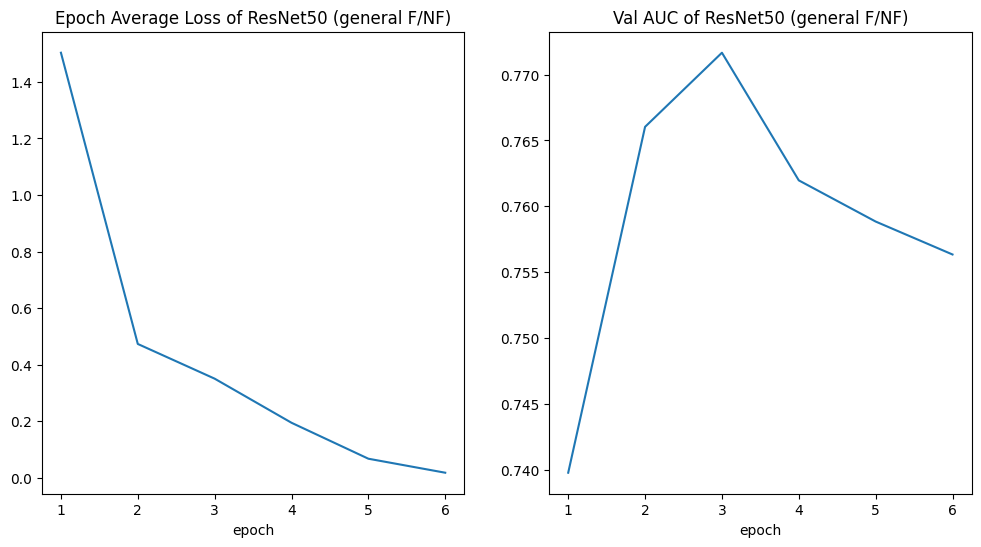

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss of ResNet50 (general F/NF)")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC of ResNet50 (general F/NF)")
x = [(i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [ ]:
model.load_state_dict(torch.load(os.path.join('./model', "f_model_resnet50.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(DEVICE),
            test_data[1].to(DEVICE)
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=['Not Fractured', 'Fractured'], digits=4))

               precision    recall  f1-score   support

Not Fractured     0.8063    0.8286    0.8173      2240
    Fractured     0.7213    0.6903    0.7055      1440

     accuracy                         0.7745      3680
    macro avg     0.7638    0.7594    0.7614      3680
 weighted avg     0.7730    0.7745    0.7735      3680



In [ ]:
np.mean([y_true[i] == y_pred[i] for i in range(len(y_true))])

np.float64(0.7744565217391305)

In [ ]:
from torchvision.models import inception_v3

model = inception_v3(weights="IMAGENET1K_V1").to(DEVICE)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
auc_metric = ROCAUCMetric()

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 172MB/s] 


In [ ]:
IMG_SIZE=299

train_tfms = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    EnsureType(dtype=np.float32),
    Lambda(func=to_3ch),
    ScaleIntensityRange(a_min=0, a_max=255, b_min=0.0, b_max=1.0, clip=True),
    Resize(spatial_size=(IMG_SIZE, IMG_SIZE)),
    RandFlip(spatial_axis=1, prob=0.5),
    RandRotate(range_x=np.deg2rad(7), prob=0.5, keep_size=True),
])

valid_tfms = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    EnsureType(dtype=np.float32),
    Lambda(func=to_3ch),
    ScaleIntensityRange(a_min=0, a_max=255, b_min=0.0, b_max=1.0, clip=True),
    Resize(spatial_size=(IMG_SIZE, IMG_SIZE)),
])

In [ ]:
train_ds = MuraDataset(train_x, train_y, train_tfms)
train_loader = DataLoader(train_ds, batch_size=32, num_workers=2)

test_ds = MuraDataset(test_x, test_y, valid_tfms)
test_loader = DataLoader(test_ds, batch_size=32, num_workers=2)

val_ds = MuraDataset(val_x, val_y, valid_tfms)
val_loader = DataLoader(val_ds, batch_size=32, num_workers=2)

In [ ]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

early_stopping = EarlyStopping(patience=5, delta=0.01)

for epoch in range(EPOCHS):
    print("-"*10)
    print(f"epoch {epoch + 1}/{EPOCHS}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(DEVICE), batch_data[1].to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs[0], labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        # Đảm bảo epoch_len được tính toán trước khi sử dụng
        epoch_len = len(train_loader)
        if step % 50 == 0:
            print(f"{step}/{epoch_len}, " f"train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % 1 == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=DEVICE)
            y = torch.tensor([], dtype=torch.long, device=DEVICE)

            # 1. Thu thập dự đoán và nhãn
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(DEVICE),
                    val_data[1].to(DEVICE)
                )
                val_outputs = model(val_images)

                y_pred = torch.cat([y_pred, val_outputs], dim=0)
                y = torch.cat([y, val_labels], dim=0)

            # --- KHU VỰC ĐÁNH GIÁ (Đã sửa cho 2 classes) ---

            # Đối với 2 classes, AUC cần xác suất (probability) của lớp tích cực (positive class).
            # Giả sử lớp tích cực là lớp thứ 1 (chỉ số 1).
            # MONAI Output thường là logits, cần Sigmoid cho Binary AUC
            y_pred_prob = torch.sigmoid(y_pred[:, 1]) # Lấy xác suất của lớp 1 sau Sigmoid

            # Tính AUC (sử dụng MONAI AUC Metric - cần y_pred và y)
            # Giả sử 'auc_metric' được khởi tạo là 'DiceMetric' hoặc tương tự
            # Tái tạo lại logic tính AUC mà không cần one-hot nếu dùng thư viện khác

            # Nếu bạn dùng MONAI ROCAUC:
            # roc_auc_metric(y_pred_prob, y)
            # result = roc_auc_metric.aggregate()
            # roc_auc_metric.reset()

            # ***TẠM THỜI SỬ DỤNG PHƯƠNG PHÁP CƠ BẢN VÀ ACCURACY***
            # Do không có định nghĩa cụ thể về 'auc_metric' và 'y_trans'
            # (Giả định 'result' là giá trị metric chính)

            # Chuyển đổi nhãn dự đoán:
            # Lấy lớp dự đoán có điểm số cao nhất (0 hoặc 1)
            y_pred_class = y_pred.argmax(dim=1)

            # 2. Tính Accuracy
            acc_value = torch.eq(y_pred_class, y)
            acc_metric = acc_value.sum().item() / len(acc_value)

            # --- TÍNH AUC (Nếu bạn muốn dùng một giá trị metric chính) ---
            # Do các hàm MONAI (y_trans, y_pred_trans, auc_metric) đã bị loại bỏ,
            # tôi sẽ giữ lại logic lưu mô hình dựa trên Accuracy (acc_metric)
            # hoặc bạn có thể thay thế bằng một metric nhị phân tùy chọn.

            # Giả sử result = acc_metric để logic lưu mô hình vẫn hoạt động
            result = acc_metric

            metric_values.append(result)

            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                # Đảm bảo root_dir đã được định nghĩa
                torch.save(model.state_dict(), os.path.join("./model", "f_model_inceptionv3.pth"))
                print("saved new best metric model")

            print(
                f"current epoch: {epoch + 1} current metric: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best metric: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

            if early_stopping(result, epoch):
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break

            # --- KẾT THÚC KHU VỰC ĐÁNH GIÁ ---
        if early_stopping.early_stop:
            break

    print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
    writer.close()

----------
epoch 1/20
50/1036, train_loss: 6.1940
100/1036, train_loss: 4.6503
150/1036, train_loss: 2.5742
200/1036, train_loss: 1.8989
250/1036, train_loss: 1.5806
300/1036, train_loss: 1.1561
350/1036, train_loss: 1.0540
400/1036, train_loss: 1.1311
450/1036, train_loss: 1.0158
500/1036, train_loss: 0.8876
550/1036, train_loss: 0.6430
600/1036, train_loss: 0.5600
650/1036, train_loss: 0.7587
700/1036, train_loss: 0.5630
750/1036, train_loss: 0.7314
800/1036, train_loss: 0.5133
850/1036, train_loss: 0.5984
900/1036, train_loss: 0.5925
950/1036, train_loss: 0.6727
1000/1036, train_loss: 0.5715
epoch 1 average loss: 1.5697
saved new best metric model
current epoch: 1 current metric: 0.7660 current accuracy: 0.7660 best metric: 0.7660 at epoch: 1
train completed, best_metric: 0.7660 at epoch: 1
----------
epoch 2/20
50/1036, train_loss: 0.5756
100/1036, train_loss: 0.6463
150/1036, train_loss: 0.4350
200/1036, train_loss: 0.4205
250/1036, train_loss: 0.5610
300/1036, train_loss: 0.3954


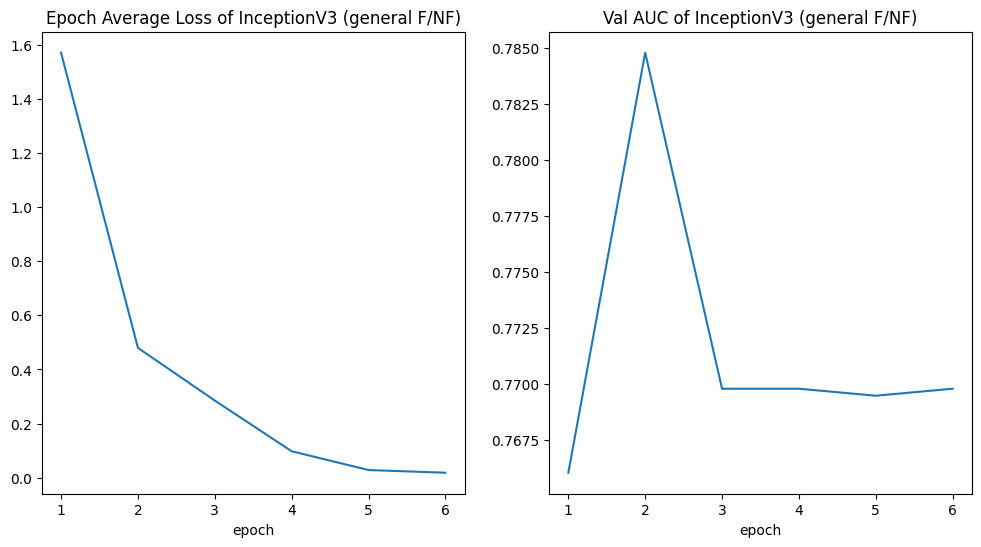

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss of InceptionV3 (general F/NF)")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC of InceptionV3 (general F/NF)")
x = [(i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [ ]:
model.load_state_dict(torch.load(os.path.join('./model', "f_model_inceptionv3.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(DEVICE),
            test_data[1].to(DEVICE)
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [ ]:
print(np.mean([y_true[i] == y_pred[i] for i in range(len(y_true))]))
print(classification_report(y_true, y_pred, target_names=['Not Fractured', 'Fractured'], digits=4))

0.7896739130434782
               precision    recall  f1-score   support

Not Fractured     0.8031    0.8670    0.8338      2240
    Fractured     0.7639    0.6694    0.7135      1440

     accuracy                         0.7897      3680
    macro avg     0.7835    0.7682    0.7737      3680
 weighted avg     0.7878    0.7897    0.7868      3680



# **Classification**

In [25]:
train_df

,image,label
0,/content/data/MURA-v1.1/train/XR_SHOULDER/pati...,0
1,/content/data/MURA-v1.1/train/XR_SHOULDER/pati...,0
2,/content/data/MURA-v1.1/train/XR_SHOULDER/pati...,0
3,/content/data/MURA-v1.1/train/XR_SHOULDER/pati...,0
4,/content/data/MURA-v1.1/train/XR_SHOULDER/pati...,1
...,...,...
36803,/content/data/MURA-v1.1/train/XR_ELBOW/patient...,0
36804,/content/data/MURA-v1.1/train/XR_ELBOW/patient...,0
36805,/content/data/MURA-v1.1/train/XR_ELBOW/patient...,0
36806,/content/data/MURA-v1.1/train/XR_ELBOW/patient...,0


In [26]:
train_df_2 = train_df.copy()

In [27]:
classes = ["ELBOW", "FINGER", "FOREARM", "HAND", "HUMERUS", "SHOULDER", "WRIST"]

In [28]:
train_df_2['label'] = train_df_2['image'].apply(lambda x: next((i for i in range(7) if classes[i] in x), None))

In [29]:
train_df_2['label'].value_counts() / len(train_df_2)

,count
label,
6,0.264942
5,0.227641
3,0.150592
1,0.138720
0,0.133965
2,0.049582
4,0.034558


In [30]:
train_df_2.head()

,image,label
0,/content/data/MURA-v1.1/train/XR_SHOULDER/pati...,5
1,/content/data/MURA-v1.1/train/XR_SHOULDER/pati...,5
2,/content/data/MURA-v1.1/train/XR_SHOULDER/pati...,5
3,/content/data/MURA-v1.1/train/XR_SHOULDER/pati...,5
4,/content/data/MURA-v1.1/train/XR_SHOULDER/pati...,5


In [31]:
val_df_2 = val_df.copy()
val_df_2['label'] = val_df_2['image'].apply(lambda x: next((i for i in range(7) if classes[i] in x), None))

In [32]:
val_df_2.head()

,image,label
0,/content/data/MURA-v1.1/valid/XR_SHOULDER/pati...,5
1,/content/data/MURA-v1.1/valid/XR_SHOULDER/pati...,5
2,/content/data/MURA-v1.1/valid/XR_SHOULDER/pati...,5
3,/content/data/MURA-v1.1/valid/XR_SHOULDER/pati...,5
4,/content/data/MURA-v1.1/valid/XR_SHOULDER/pati...,5


In [ ]:
model = resnet50(weights="IMAGENET1K_V2").to(DEVICE)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
auc_metric = ROCAUCMetric()

In [33]:
from sklearn.model_selection import StratifiedShuffleSplit

test_frac = 0.1
num_total = len(train_df_2)

# Create StratifiedShuffleSplit for stratified sampling
sss = StratifiedShuffleSplit(n_splits=1, test_size=test_frac, random_state=42)

# Splitting train and test indices
for train_index, test_index in sss.split(np.zeros(num_total), train_df_2['label']):
    train_indices, test_indices = train_index, test_index

# Assign train and test data based on stratified sampling
train_x = [train_df_2['image'][i] for i in train_indices]
train_y = [train_df_2['label'][i] for i in train_indices]
test_x = [train_df_2['image'][i] for i in test_indices]
test_y = [train_df_2['label'][i] for i in test_indices]

indices_val = np.arange(len(val_df))
np.random.shuffle(indices_val)
val_x = [val_df_2['image'][i] for i in indices_val]
val_y = [val_df_2['label'][i] for i in indices_val]

# Print the counts to verify class distribution
print(f"Training count: {len(train_y)}, Validation count: {len(val_y)}, Test count: {len(test_y)}")


Training count: 33127, Validation count: 3197, Test count: 3681


In [ ]:
train_ds = MuraDataset(train_x, train_y, train_tfms)
train_loader = DataLoader(train_ds, batch_size=32, num_workers=2)

test_ds = MuraDataset(test_x, test_y, valid_tfms)
test_loader = DataLoader(test_ds, batch_size=32, num_workers=2)

val_ds = MuraDataset(val_x, val_y, valid_tfms)
val_loader = DataLoader(val_ds, batch_size=32, num_workers=2)

In [ ]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

early_stopping = EarlyStopping(patience=5, delta=0.01)

for epoch in range(EPOCHS):
    print("-"*10)
    print(f"epoch {epoch + 1}/{EPOCHS}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(DEVICE), batch_data[1].to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        # Đảm bảo epoch_len được tính toán trước khi sử dụng
        epoch_len = len(train_loader)
        if step % 50 == 0:
            print(f"{step}/{epoch_len}, " f"train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % 1 == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=DEVICE)
            y = torch.tensor([], dtype=torch.long, device=DEVICE)

            # 1. Thu thập dự đoán và nhãn
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(DEVICE),
                    val_data[1].to(DEVICE)
                )
                val_outputs = model(val_images)

                y_pred = torch.cat([y_pred, val_outputs], dim=0)
                y = torch.cat([y, val_labels], dim=0)

            # --- KHU VỰC ĐÁNH GIÁ (Đã sửa cho 2 classes) ---

            # Đối với 2 classes, AUC cần xác suất (probability) của lớp tích cực (positive class).
            # Giả sử lớp tích cực là lớp thứ 1 (chỉ số 1).
            # MONAI Output thường là logits, cần Sigmoid cho Binary AUC
            y_pred_prob = torch.sigmoid(y_pred[:, 1]) # Lấy xác suất của lớp 1 sau Sigmoid

            # Tính AUC (sử dụng MONAI AUC Metric - cần y_pred và y)
            # Giả sử 'auc_metric' được khởi tạo là 'DiceMetric' hoặc tương tự
            # Tái tạo lại logic tính AUC mà không cần one-hot nếu dùng thư viện khác

            # Nếu bạn dùng MONAI ROCAUC:
            # roc_auc_metric(y_pred_prob, y)
            # result = roc_auc_metric.aggregate()
            # roc_auc_metric.reset()

            # ***TẠM THỜI SỬ DỤNG PHƯƠNG PHÁP CƠ BẢN VÀ ACCURACY***
            # Do không có định nghĩa cụ thể về 'auc_metric' và 'y_trans'
            # (Giả định 'result' là giá trị metric chính)

            # Chuyển đổi nhãn dự đoán:
            # Lấy lớp dự đoán có điểm số cao nhất (0 hoặc 1)
            y_pred_class = y_pred.argmax(dim=1)

            # 2. Tính Accuracy
            acc_value = torch.eq(y_pred_class, y)
            acc_metric = acc_value.sum().item() / len(acc_value)

            # --- TÍNH AUC (Nếu bạn muốn dùng một giá trị metric chính) ---
            # Do các hàm MONAI (y_trans, y_pred_trans, auc_metric) đã bị loại bỏ,
            # tôi sẽ giữ lại logic lưu mô hình dựa trên Accuracy (acc_metric)
            # hoặc bạn có thể thay thế bằng một metric nhị phân tùy chọn.

            # Giả sử result = acc_metric để logic lưu mô hình vẫn hoạt động
            result = acc_metric

            metric_values.append(result)

            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                # Đảm bảo root_dir đã được định nghĩa
                torch.save(model.state_dict(), os.path.join("./model", "c_model_resnet50.pth"))
                print("saved new best metric model")

            print(
                f"current epoch: {epoch + 1} current metric: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best metric: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

            if early_stopping(result, epoch):
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break

            # --- KẾT THÚC KHU VỰC ĐÁNH GIÁ ---
        if early_stopping.early_stop:
            break

    print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
    writer.close()

----------
epoch 1/20
50/1036, train_loss: 5.5858
100/1036, train_loss: 3.8042
150/1036, train_loss: 1.9479
200/1036, train_loss: 1.2818
250/1036, train_loss: 1.0087
300/1036, train_loss: 0.8368
350/1036, train_loss: 0.5613
400/1036, train_loss: 0.5645
450/1036, train_loss: 0.2662
500/1036, train_loss: 0.5530
550/1036, train_loss: 0.1453
600/1036, train_loss: 0.3006
650/1036, train_loss: 0.1032
700/1036, train_loss: 0.3787
750/1036, train_loss: 0.1938
800/1036, train_loss: 0.1011
850/1036, train_loss: 0.1377
900/1036, train_loss: 0.1797
950/1036, train_loss: 0.3366
1000/1036, train_loss: 0.2463
epoch 1 average loss: 1.1446
saved new best metric model
current epoch: 1 current metric: 0.9112 current accuracy: 0.9112 best metric: 0.9112 at epoch: 1
train completed, best_metric: 0.9112 at epoch: 1
----------
epoch 2/20
50/1036, train_loss: 0.4752
100/1036, train_loss: 0.2337
150/1036, train_loss: 0.1008
200/1036, train_loss: 0.1198
250/1036, train_loss: 0.0730
300/1036, train_loss: 0.0970


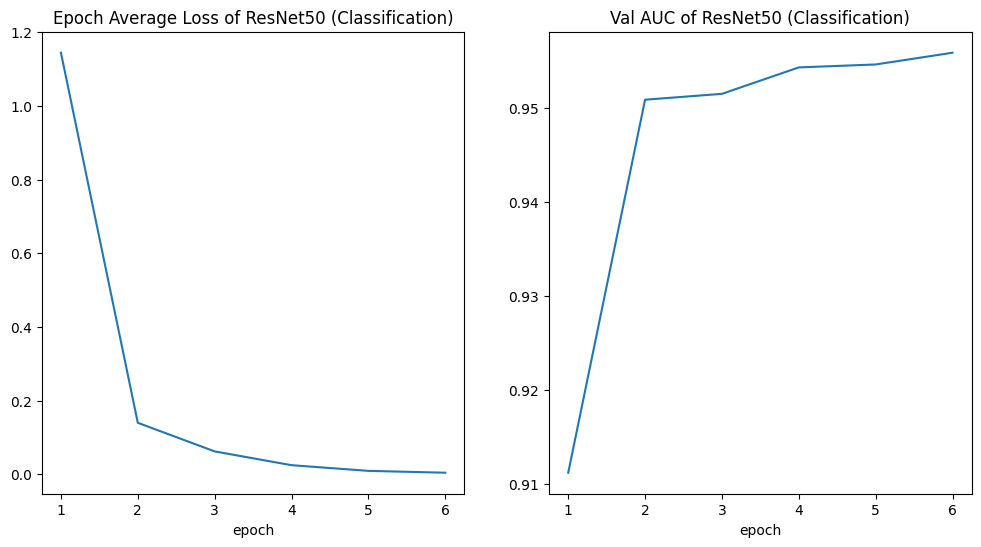

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss of ResNet50 (Classification)")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC of ResNet50 (Classification)")
x = [(i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [ ]:
model.load_state_dict(torch.load(os.path.join('./model', "c_model_resnet50.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(DEVICE),
            test_data[1].to(DEVICE)
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [ ]:
print(np.mean([y_true[i] == y_pred[i] for i in range(len(y_true))]))
print(classification_report(y_true, y_pred, target_names=classes, digits=4))

0.9731051344743277
              precision    recall  f1-score   support

       ELBOW     0.9817    0.9797    0.9807       493
      FINGER     0.9779    0.9530    0.9653       511
     FOREARM     0.9651    0.9071    0.9352       183
        HAND     0.9575    0.9765    0.9669       554
     HUMERUS     0.8947    0.9370    0.9154       127
    SHOULDER     0.9904    0.9893    0.9899       838
       WRIST     0.9726    0.9815    0.9770       975

    accuracy                         0.9731      3681
   macro avg     0.9629    0.9606    0.9615      3681
weighted avg     0.9733    0.9731    0.9731      3681



In [34]:
from torchvision.models import inception_v3
from monai.metrics import ROCAUCMetric

model = inception_v3(weights="IMAGENET1K_V1").to(DEVICE)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
auc_metric = ROCAUCMetric()

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:01<00:00, 83.5MB/s]


In [35]:
IMG_SIZE=299

train_tfms = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    EnsureType(dtype=np.float32),
    Lambda(func=to_3ch),
    ScaleIntensityRange(a_min=0, a_max=255, b_min=0.0, b_max=1.0, clip=True),
    Resize(spatial_size=(IMG_SIZE, IMG_SIZE)),
    RandFlip(spatial_axis=1, prob=0.5),
    RandRotate(range_x=np.deg2rad(7), prob=0.5, keep_size=True),
])

valid_tfms = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    EnsureType(dtype=np.float32),
    Lambda(func=to_3ch),
    ScaleIntensityRange(a_min=0, a_max=255, b_min=0.0, b_max=1.0, clip=True),
    Resize(spatial_size=(IMG_SIZE, IMG_SIZE)),
])

In [36]:
train_ds = MuraDataset(train_x, train_y, train_tfms)
train_loader = DataLoader(train_ds, batch_size=32, num_workers=2)

test_ds = MuraDataset(test_x, test_y, valid_tfms)
test_loader = DataLoader(test_ds, batch_size=32, num_workers=2)

val_ds = MuraDataset(val_x, val_y, valid_tfms)
val_loader = DataLoader(val_ds, batch_size=32, num_workers=2)

In [38]:
from torch.utils.tensorboard import SummaryWriter

best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

early_stopping = EarlyStopping(patience=5, delta=0.01)

for epoch in range(EPOCHS):
    print("-"*10)
    print(f"epoch {epoch + 1}/{EPOCHS}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(DEVICE), batch_data[1].to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs[0], labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        # Đảm bảo epoch_len được tính toán trước khi sử dụng
        epoch_len = len(train_loader)
        if step % 50 == 0:
            print(f"{step}/{epoch_len}, " f"train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % 1 == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=DEVICE)
            y = torch.tensor([], dtype=torch.long, device=DEVICE)

            # 1. Thu thập dự đoán và nhãn
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(DEVICE),
                    val_data[1].to(DEVICE)
                )
                val_outputs = model(val_images)

                y_pred = torch.cat([y_pred, val_outputs], dim=0)
                y = torch.cat([y, val_labels], dim=0)

            # --- KHU VỰC ĐÁNH GIÁ (Đã sửa cho 2 classes) ---

            # Đối với 2 classes, AUC cần xác suất (probability) của lớp tích cực (positive class).
            # Giả sử lớp tích cực là lớp thứ 1 (chỉ số 1).
            # MONAI Output thường là logits, cần Sigmoid cho Binary AUC
            y_pred_prob = torch.sigmoid(y_pred[:, 1]) # Lấy xác suất của lớp 1 sau Sigmoid

            # Tính AUC (sử dụng MONAI AUC Metric - cần y_pred và y)
            # Giả sử 'auc_metric' được khởi tạo là 'DiceMetric' hoặc tương tự
            # Tái tạo lại logic tính AUC mà không cần one-hot nếu dùng thư viện khác

            # Nếu bạn dùng MONAI ROCAUC:
            # roc_auc_metric(y_pred_prob, y)
            # result = roc_auc_metric.aggregate()
            # roc_auc_metric.reset()

            # ***TẠM THỜI SỬ DỤNG PHƯƠNG PHÁP CƠ BẢN VÀ ACCURACY***
            # Do không có định nghĩa cụ thể về 'auc_metric' và 'y_trans'
            # (Giả định 'result' là giá trị metric chính)

            # Chuyển đổi nhãn dự đoán:
            # Lấy lớp dự đoán có điểm số cao nhất (0 hoặc 1)
            y_pred_class = y_pred.argmax(dim=1)

            # 2. Tính Accuracy
            acc_value = torch.eq(y_pred_class, y)
            acc_metric = acc_value.sum().item() / len(acc_value)

            # --- TÍNH AUC (Nếu bạn muốn dùng một giá trị metric chính) ---
            # Do các hàm MONAI (y_trans, y_pred_trans, auc_metric) đã bị loại bỏ,
            # tôi sẽ giữ lại logic lưu mô hình dựa trên Accuracy (acc_metric)
            # hoặc bạn có thể thay thế bằng một metric nhị phân tùy chọn.

            # Giả sử result = acc_metric để logic lưu mô hình vẫn hoạt động
            result = acc_metric

            metric_values.append(result)

            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                # Đảm bảo root_dir đã được định nghĩa
                torch.save(model.state_dict(), os.path.join("./model", "c_model_inceptionv3.pth"))
                print("saved new best metric model")

            print(
                f"current epoch: {epoch + 1} current metric: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best metric: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

            if early_stopping(result, epoch):
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break

            # --- KẾT THÚC KHU VỰC ĐÁNH GIÁ ---
        if early_stopping.early_stop:
            break

    print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
    writer.close()

----------
epoch 1/20
50/1036, train_loss: 5.9169
100/1036, train_loss: 3.6937
150/1036, train_loss: 1.6692
200/1036, train_loss: 1.0730
250/1036, train_loss: 1.0001
300/1036, train_loss: 0.6605
350/1036, train_loss: 0.3872
400/1036, train_loss: 0.4220
450/1036, train_loss: 0.1338
500/1036, train_loss: 0.1570
550/1036, train_loss: 0.1108
600/1036, train_loss: 0.1508
650/1036, train_loss: 0.0452
700/1036, train_loss: 0.4128
750/1036, train_loss: 0.3458
800/1036, train_loss: 0.1404
850/1036, train_loss: 0.1325
900/1036, train_loss: 0.1190
950/1036, train_loss: 0.3682
1000/1036, train_loss: 0.1397
epoch 1 average loss: 1.0960
saved new best metric model
current epoch: 1 current metric: 0.9374 current accuracy: 0.9374 best metric: 0.9374 at epoch: 1
train completed, best_metric: 0.9374 at epoch: 1
----------
epoch 2/20
50/1036, train_loss: 0.6294
100/1036, train_loss: 0.1708
150/1036, train_loss: 0.1636
200/1036, train_loss: 0.2063
250/1036, train_loss: 0.0753
300/1036, train_loss: 0.1586


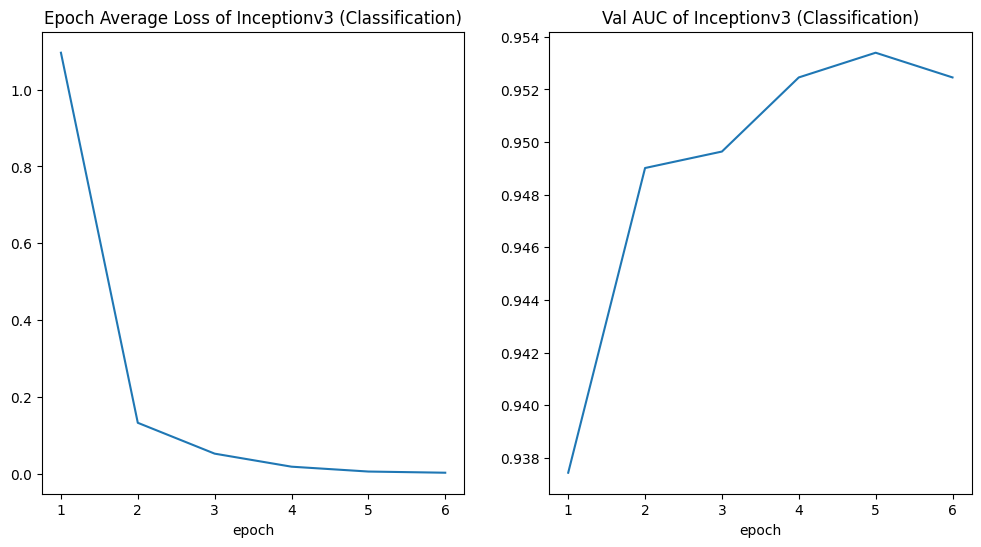

In [39]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss of Inceptionv3 (Classification)")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC of Inceptionv3 (Classification)")
x = [(i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [41]:
model.load_state_dict(torch.load(os.path.join('./model', "c_model_inceptionv3.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(DEVICE),
            test_data[1].to(DEVICE)
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [43]:
from sklearn.metrics import classification_report

print(np.mean([y_true[i] == y_pred[i] for i in range(len(y_true))]))
print(classification_report(y_true, y_pred, target_names=classes, digits=4))

0.9750067916327085
              precision    recall  f1-score   support

       ELBOW     0.9677    0.9716    0.9696       493
      FINGER     0.9860    0.9628    0.9743       511
     FOREARM     0.9322    0.9016    0.9167       183
        HAND     0.9613    0.9874    0.9742       554
     HUMERUS     0.9225    0.9370    0.9297       127
    SHOULDER     0.9940    0.9940    0.9940       838
       WRIST     0.9795    0.9785    0.9790       975

    accuracy                         0.9750      3681
   macro avg     0.9633    0.9618    0.9625      3681
weighted avg     0.9751    0.9750    0.9750      3681

